In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
from nltk import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.preprocessing import LabelEncoder
from string import punctuation
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model

In [40]:
data = pd.read_csv('twitter_reviews.csv',header = None,names=['label','Text'])
data.head()

,label,Text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


## Data Preprocessing

In [5]:
data['label'].value_counts()

label
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   74682 non-null  object
 1   Text    73996 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [7]:
data.isna().sum()

label      0
Text     686
dtype: int64

In [8]:
data.isnull().sum()

label      0
Text     686
dtype: int64

In [9]:
data.dropna(inplace= True)

In [10]:
data = data.iloc[:30000,:]

In [11]:
data.shape

(30000, 2)

In [12]:
stop_words = stopwords.words('english')

In [13]:
stemmer = PorterStemmer()

In [14]:
translator = str.maketrans('','',punctuation)

In [15]:
clean_data = pd.DataFrame(columns=['Text','Label'])

In [16]:
for index , row in data.iterrows():
    text = row['Text']
    tokens = word_tokenize(text)
    punc_removes = [word.translate(translator) for word in tokens]
    stop_removes = [word for word in punc_removes if not word in stop_words]
    stem_words = [stemmer.stem(word) for word in stop_removes]
    clean_data.loc[index] = {
        'Text' : ' '.join(stem_words),
        'Label' : row['label']
    }

In [17]:
pattern = r'[^\w\s]'
clean_data['Text'] = clean_data['Text'].replace(pattern, '', regex=True)

In [18]:
max_len = len(clean_data['Text'].max())
if max_len < len(stem_words):
    max_len = len(stem_words)
print(max_len)

21


In [19]:
clean_data.head()

,Text,Label
0,im get borderland murder,Positive
1,i come border i kill,Positive
2,im get borderland kill,Positive
3,im come borderland murder,Positive
4,im get borderland 2 murder,Positive


In [20]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 0 to 30264
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    30000 non-null  object
 1   Label   30000 non-null  object
dtypes: object(2)
memory usage: 703.1+ KB


## Exploratory data analysis

                                             |                                             | [  0%]   00:00 ->…


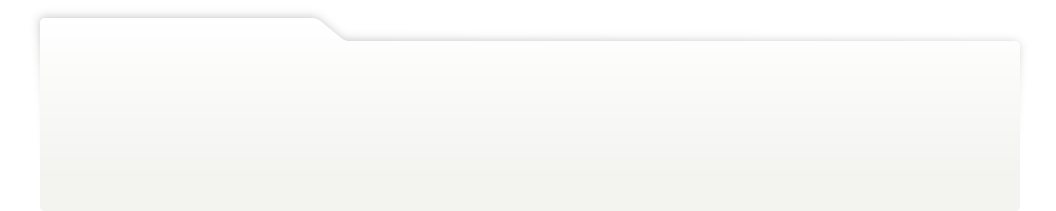
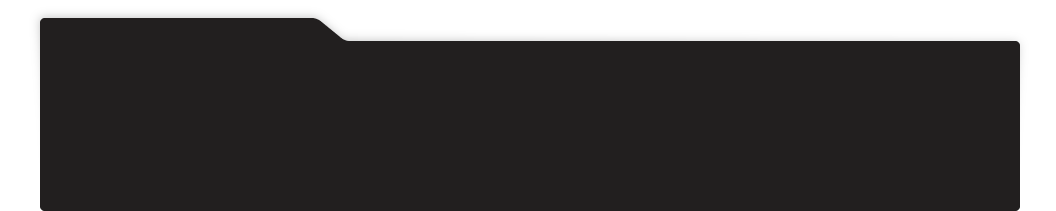
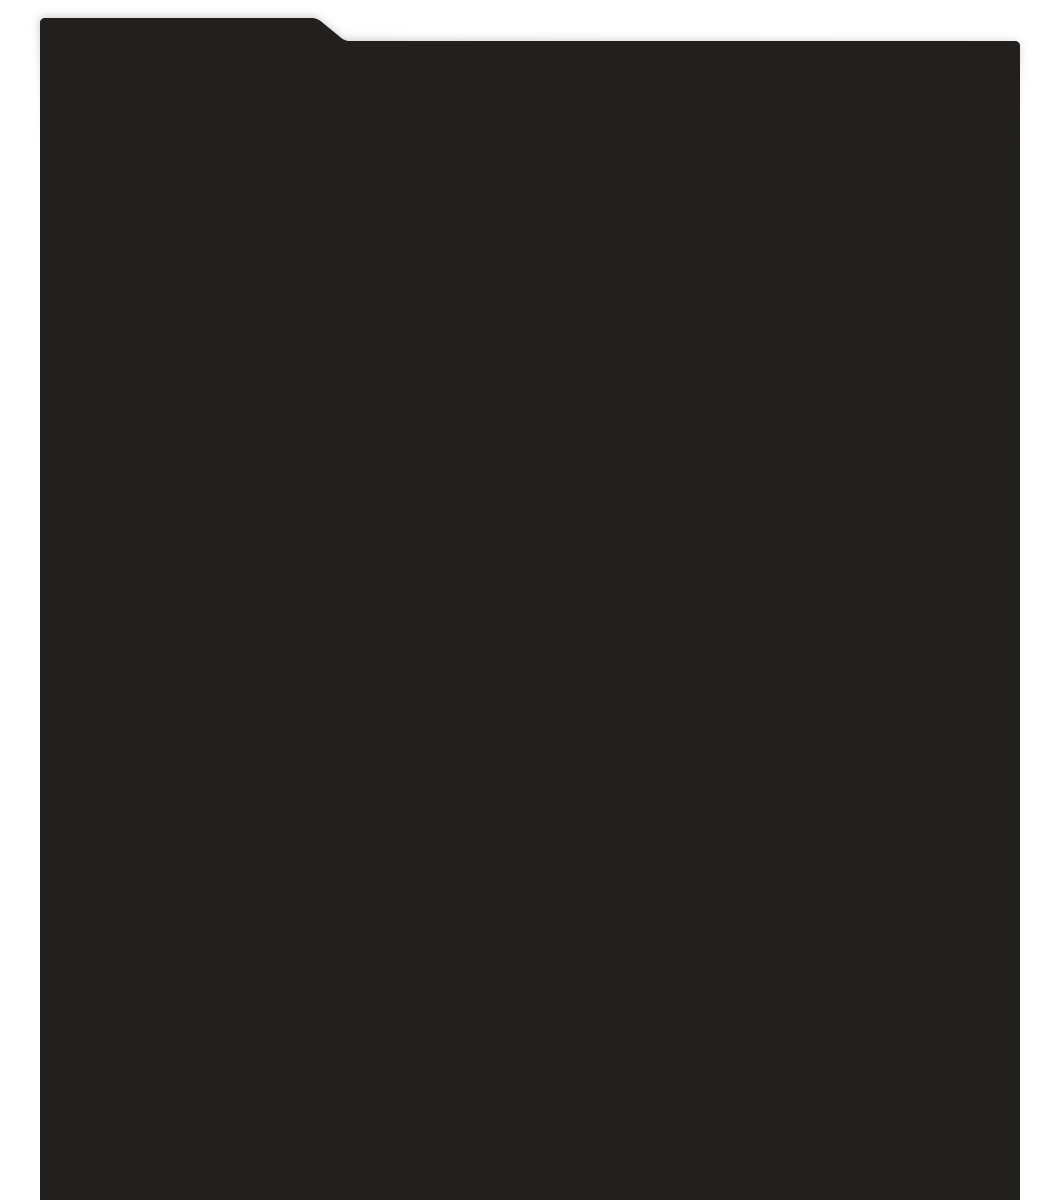
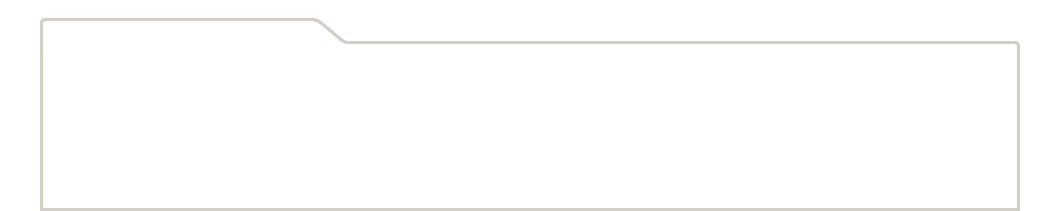
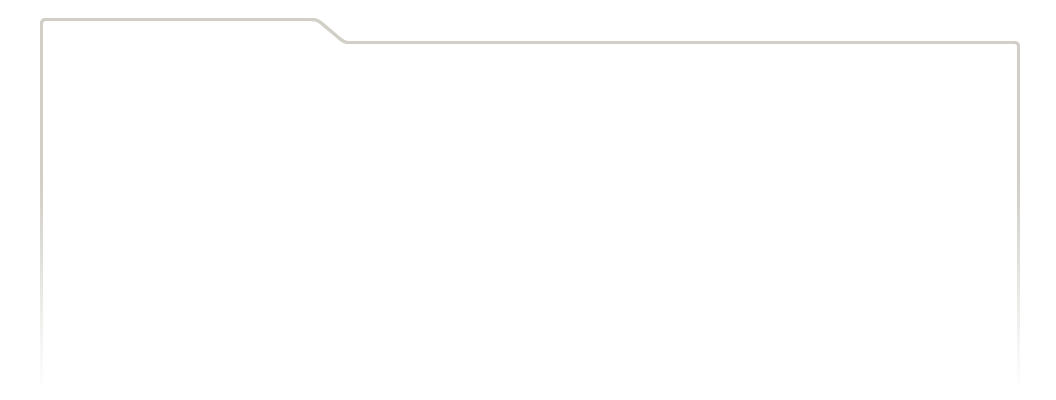
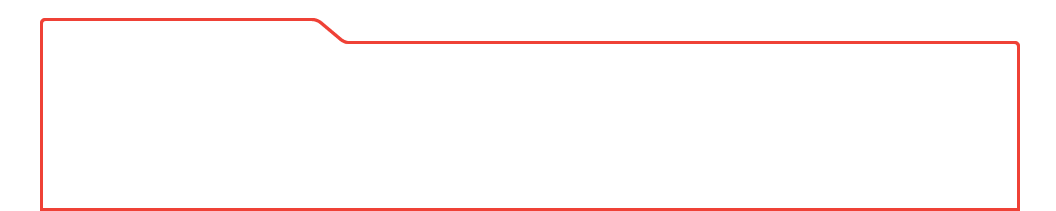
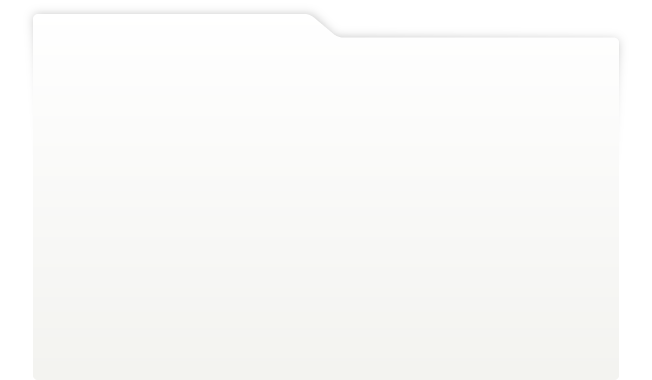
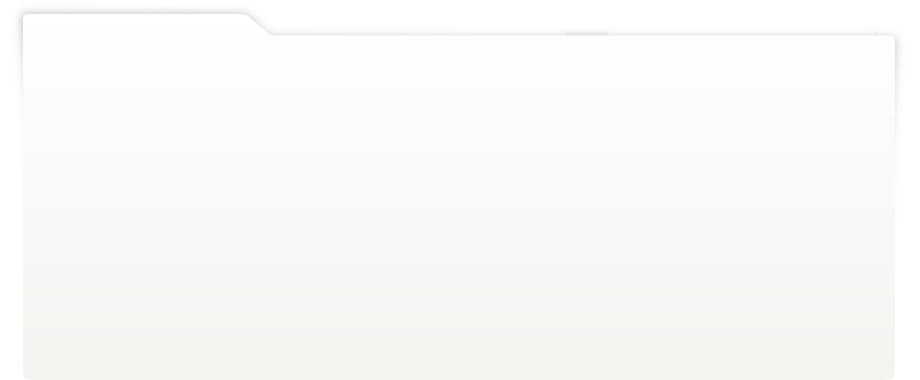
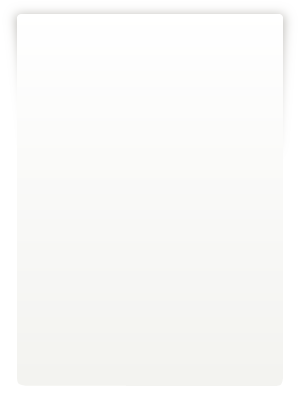
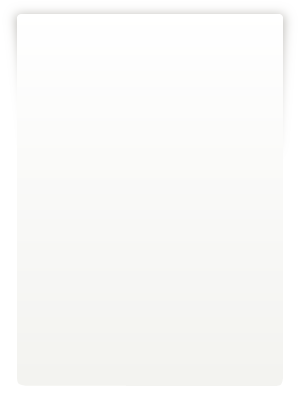
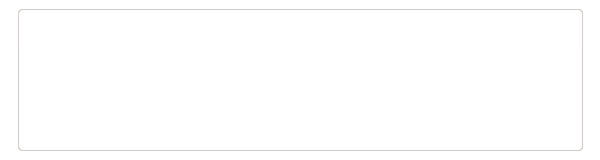
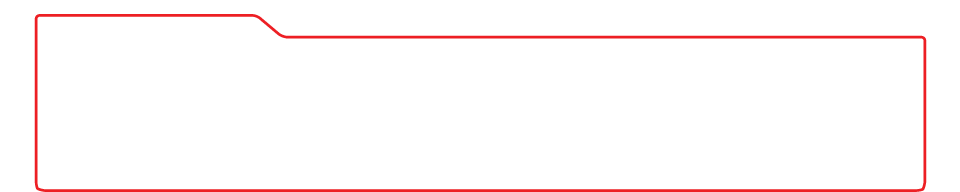
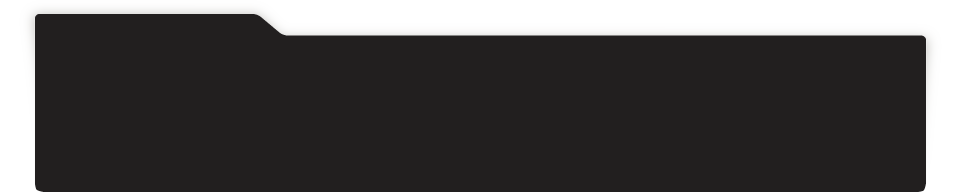
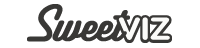
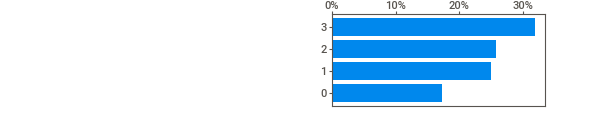
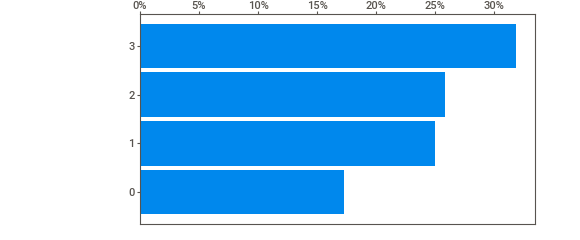
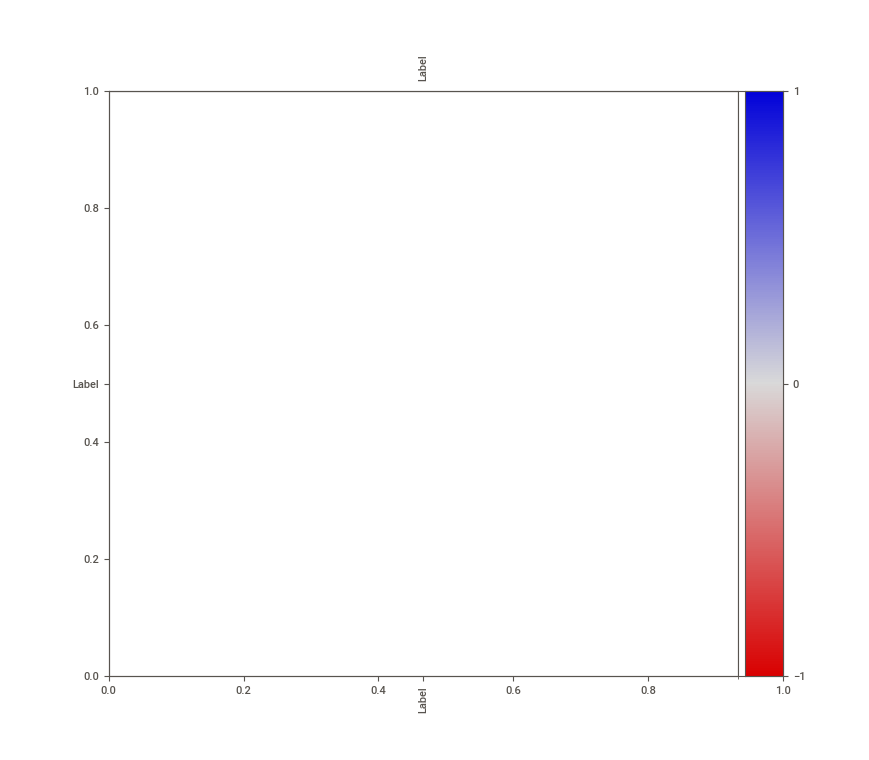
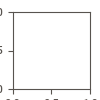

In [43]:
data_report = sv.analyze(clean_data)
data_report.show_notebook()

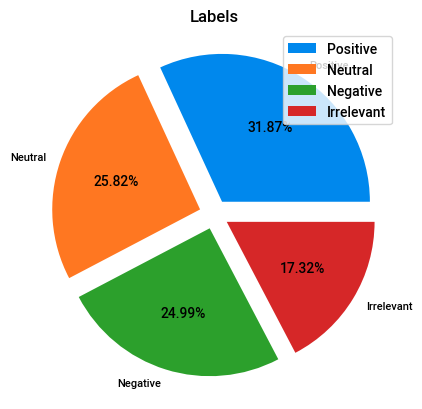

In [22]:
plt.pie(x = clean_data['Label'].value_counts(), labels = clean_data['Label'].unique(), autopct = '%1.2f%%',explode=[0.1,0.1,0.1,0.1]);plt.title('Labels')
plt.legend(loc='upper right')

## Data preprocessing 2 

In [23]:
encoder = LabelEncoder()
clean_data['Label'] = encoder.fit_transform(clean_data['Label'])
clean_data['Label'].value_counts() # Negativ = 1 & Positiv = 3 & Neutral  = 2  & Irrelevant = 0

Label
3    9561
2    7746
1    7498
0    5195
Name: count, dtype: int64

In [24]:
X = clean_data.iloc[:,0]
y = clean_data.iloc[:,1]
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.2,shuffle=True)

In [25]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_len = len(tokenizer.word_index) +1
print(vocab_len)

15161


In [26]:
sequenced = tokenizer.texts_to_sequences(X_train)
padded = pad_sequences(sequenced, maxlen=max_len, padding='post')

In [27]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_test)

In [28]:
test_sequenced = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(sequenced, maxlen=max_len, padding='post')

##  Model Building and evaluation

### Deep Model

In [26]:
padded.shape

(24000, 21)

In [29]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(max_len,)),
    keras.layers.Embedding(vocab_len, 100),
    keras.layers.Conv1D(32,4,activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPool1D(2),
    keras.layers.Conv1D(64,4,activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPool1D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(100,activation='relu'),
    keras.layers.Dense(75,activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(50,activation='relu'),
    keras.layers.Dense(10,activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(4,activation='softmax'),
])

In [30]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 21, 100)             │       1,521,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 18, 32)              │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 18, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 9, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 6, 64)               │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 3, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │          19,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 75)                  │           7,575 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 75)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 50)                  │           3,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             510 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4)                   │              44 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,573,517 (6.00 MB)

 Trainable params: 1,573,517 (6.00 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [47]:
call_back = keras.callbacks.EarlyStopping(patience=2)

In [48]:
y_array = np.array(y_train)

In [49]:
history = model.fit(x=padded,y=y_array,epochs=30,callbacks=[call_back],validation_split=0.2)

Epoch 1/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.3678 - loss: 1.3079 - val_accuracy: 0.6404 - val_loss: 0.8772
Epoch 2/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.7063 - loss: 0.7548 - val_accuracy: 0.7685 - val_loss: 0.6195
Epoch 3/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.8359 - loss: 0.4342 - val_accuracy: 0.8229 - val_loss: 0.4994
Epoch 4/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.8998 - loss: 0.2774 - val_accuracy: 0.8485 - val_loss: 0.4635
Epoch 5/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9266 - loss: 0.1997 - val_accuracy: 0.8648 - val_loss: 0.4863
Epoch 6/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9364 - loss: 0.1745 - val_accuracy: 0.8602 - val_loss: 0.4875


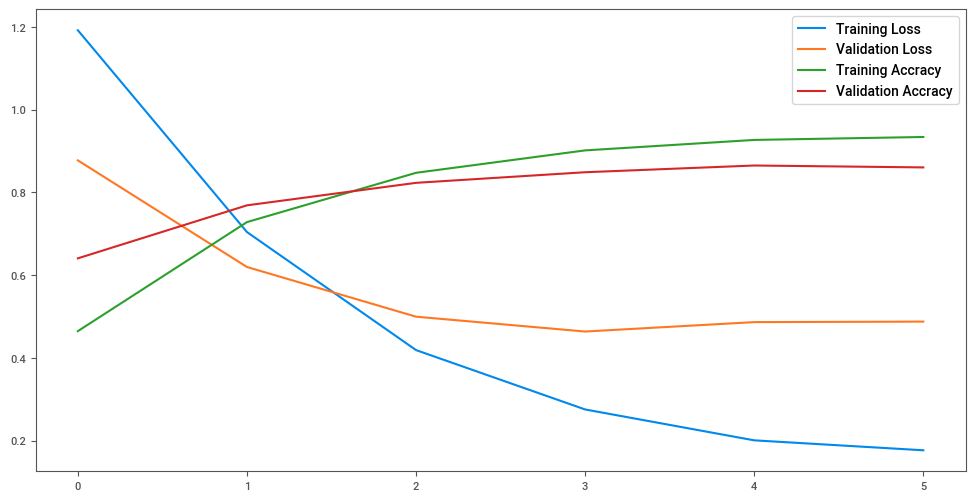

In [52]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accracy')
plt.plot(history.history['val_accuracy'], label='Validation Accracy')
plt.legend()
plt.show()

# for nlp tasks, in addition to building deep learning models, if your keras version is  3.1.0, you can use huggong face pipeline because it makes the task much easier.(https://huggingface.co/blog/sentiment-analysis-python)